In [65]:
import jax
import jax.numpy as jnp
import jax.random as jr

from jax_moseq.utils.autoregression import random_rotation

from jax_moseq.models import twarhmm

from tqdm.auto import trange
import matplotlib.pyplot as plt

import seaborn as sns
from dynamax.utils.plotting import gradient_cmap

sns.set_style("white")
sns.set_context("talk")


color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink",
    "greyish",
    "mint",
    "cyan",
    "steel blue",
    "forest green",
    "charcoal",
    "salmon",
    "dark brown",
    "jade",
    "tan",
    "lavender",
    "dark magenta",
    "olive",
    "peach",
    "golden",
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


In [66]:
def print_dict(d, depth=0, ind='  '):
    if type(d) != dict:
        try:
            item = d.shape
        except AttributeError:
            item = d
        print(f'{ind * depth}{item}')
        return
    
    for k, v in d.items():
        print(f'{ind * depth}{k}')
        print_dict(v, depth + 1, ind)

In [67]:
# DATA GENERATION
# define model parameters
true_num_states = 5
num_sessions = 1
num_timesteps = 20000
emission_dim = 2
seed = jr.PRNGKey(23)
tau_values = jnp.array([0.75, 1, 1.33])

# weights + biases for starfish
keys = jr.split(jr.PRNGKey(0), true_num_states)
angles = jnp.linspace(0, 2 * jnp.pi, true_num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((true_num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (true_num_states, 1, 1))

true_Ab = jnp.concatenate((weights - jnp.eye(2), biases[:,:,None]), axis=-1)
true_Q = covariances

# transitions
transition_probs = 0.1 ** jnp.arange(true_num_states)
transition_probs /= transition_probs.sum()
transition_matrix = jax.vmap(lambda k: jnp.roll(transition_probs, k))(jnp.arange(true_num_states))

true_pi_z = transition_matrix
true_pi_t = jnp.array([[0.90, 0.10, 0.00], 
                  [0.05, 0.90, 0.05],
                  [0.00, 0.10, 0.90]])


In [68]:
true_zs, true_ts, xs = jax.vmap(
    lambda seed: twarhmm.generate.generate_states(seed, true_pi_z, true_pi_t, true_Ab, true_Q, tau_values, num_timesteps)
    )(jr.split(seed, num_sessions))

data = {'x': jax.device_put(xs),
        'mask': jax.device_put(jnp.ones_like(true_zs))} #TODO: get rid of masks

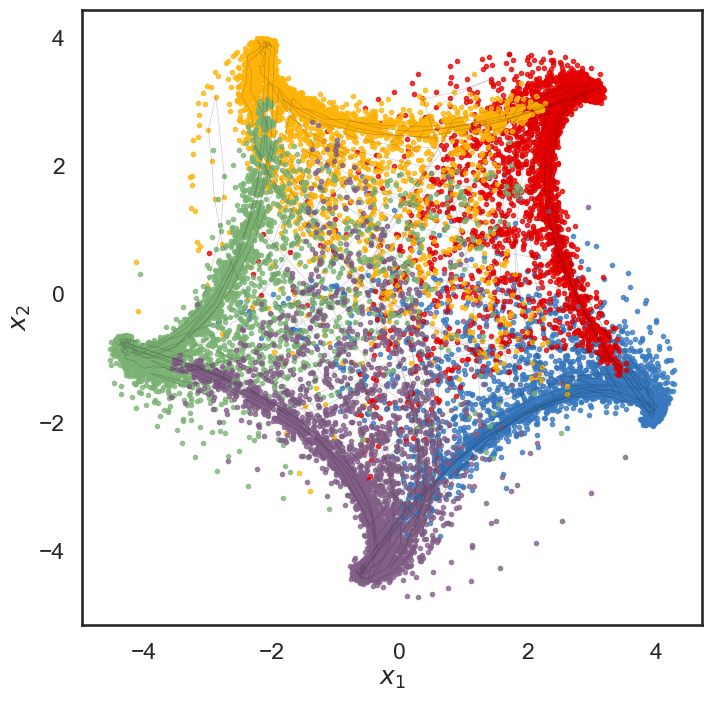

In [69]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(true_num_states):
    plt.plot(*xs[0][true_zs[0]==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect(1.0)

In [70]:
latent_dim = obs_dim = data['x'].shape[-1]
num_states = 10          # max number of states

trans_hypparams = {
    'beta': 100.0,
    'kappa': 100.0,
    'num_states':num_states,
    't_stick': 0.95
}

ar_hypparams = {
    'S_0_scale': .01,
    'K_0_scale': 10,
    'num_states':num_states,
    'nlags':  1,
    'latent_dim': latent_dim,
    'tau_values': tau_values
}

In [71]:
init_seed = jr.PRNGKey(2)
model = twarhmm.init_model(data,
                           seed=seed,
                           ar_hypparams=ar_hypparams,
                           trans_hypparams=trans_hypparams,
                           verbose=True)

# print_dict(model)

TWARHMM: Initializing hyperparameters
TWARHMM: Initializing parameters
TWARHMM: Initializing states


In [72]:
# # initialize with the true params
# model["params"]["Ab"] = true_Ab
# model["params"]["Q"] = true_Q
# model['params']['pi_z'] = true_pi_z
# model['params']['pi_t'] = true_pi_t

# # Resample the states once to be consistent with the params
# model["states"] = twarhmm.init_states(jr.PRNGKey(0), data["x"], data["mask"], model["params"])

# initialize with the true states
# model["states"] = {'z': true_zs[:, 1:], 't': true_ts[:, 1:]}

In [73]:
num_iters = 100    # number of training iterations

ll_keys = ['z', 'x', 't']
ll_history = {key: [] for key in ll_keys}

for i in trange(num_iters):
    # Perform Gibbs resampling
    ll = twarhmm.model_likelihood(data, **model)
    model = twarhmm.resample_model(data, **model, states_only=False)
    
    # Compute the likelihood of the data and
    # resampled states given the resampled params
    for key in ll_keys:
        ll_history[key].append(ll[key].item())

100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


In [74]:
def plot_ll(key, ll_history):
    plt.title(f'Log Likelihood of {key}')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.plot(ll_history)
    plt.show()

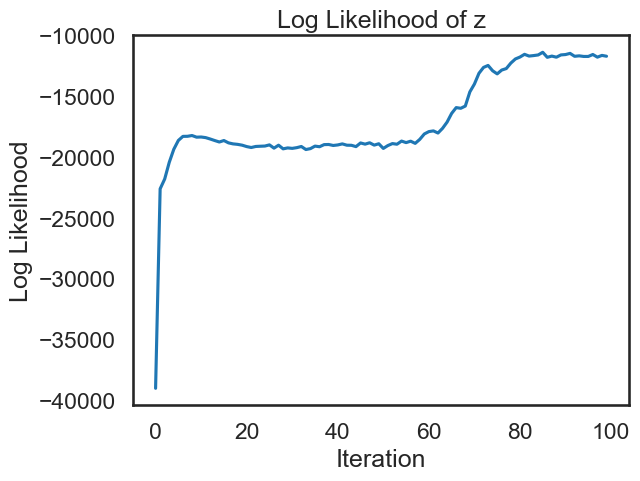

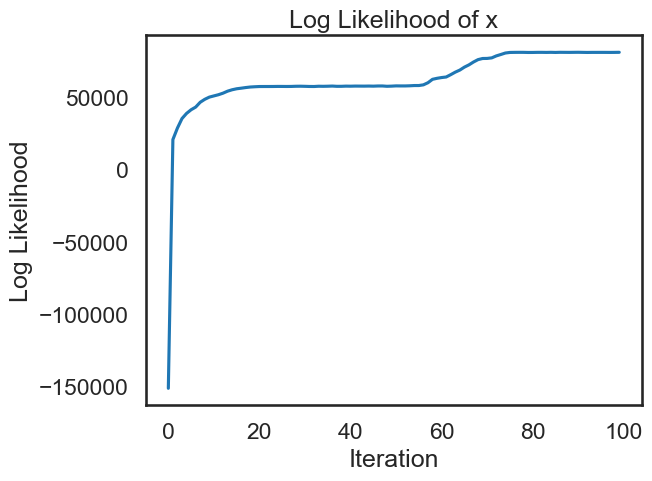

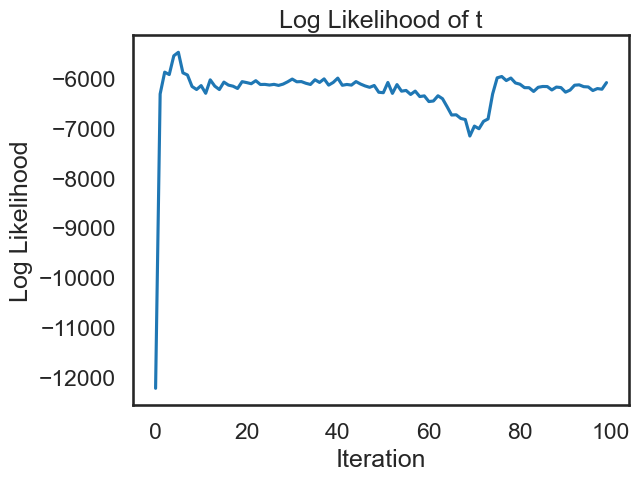

In [75]:
for k, v in ll_history.items():
    plot_ll(k, v)

Text(0, 0.5, '$x_2$')

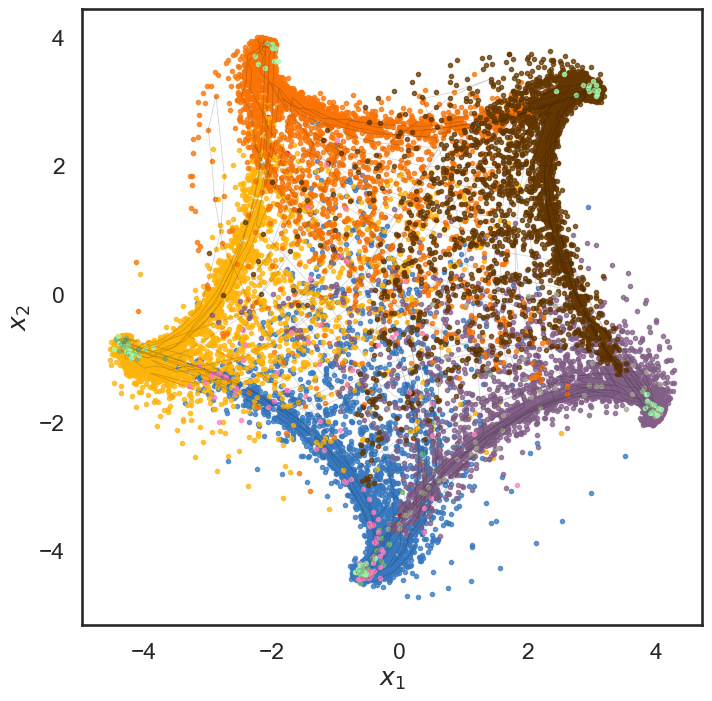

In [76]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[0,1:][model['states']['z'][0]==k].T, 'o',
         color=colors[k], alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

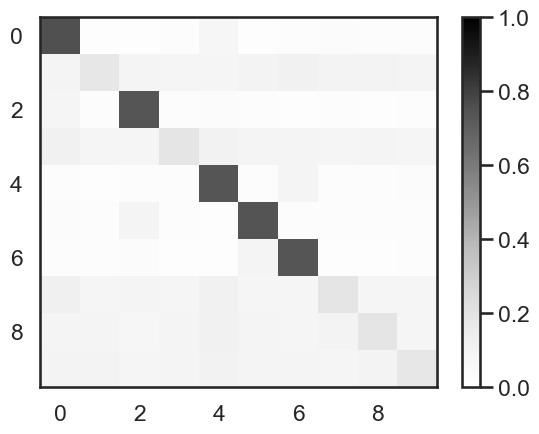

In [77]:
plt.imshow(model['params']['pi_z'], cmap="Greys", 
           interpolation="nearest", aspect="auto",
           vmin=0, vmax=1)
plt.colorbar()

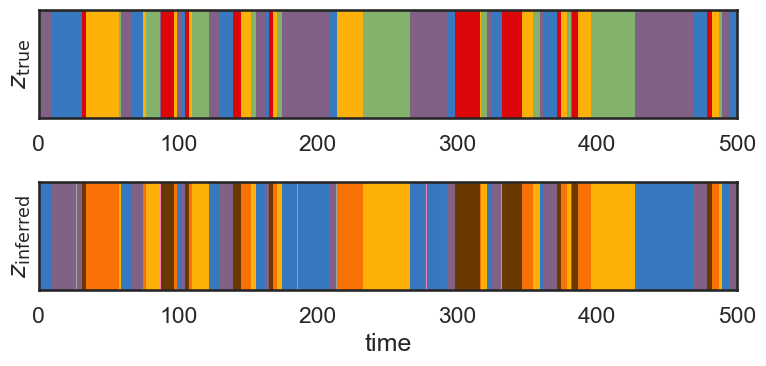

In [78]:
plot_slice = (0, 500)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_zs[None, 0, ar_hypparams['nlags']:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(model['states']['z'][None,0,:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

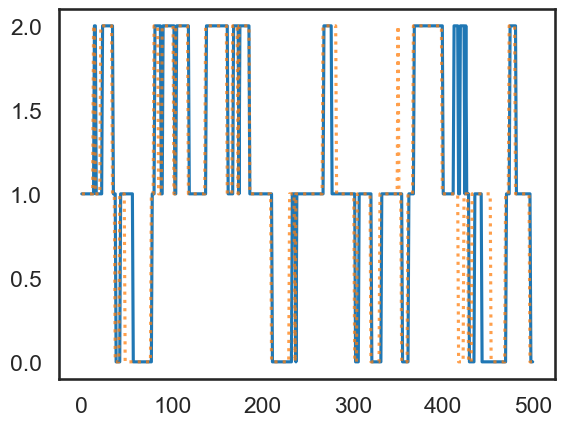

In [79]:
plt.plot(true_ts[0,:500], )
plt.plot(model['states']['t'][0,:500], ':', alpha=0.75, markersize=3)

## Compute the overlap between true and inferred states

Text(0, 0.5, 'true state')

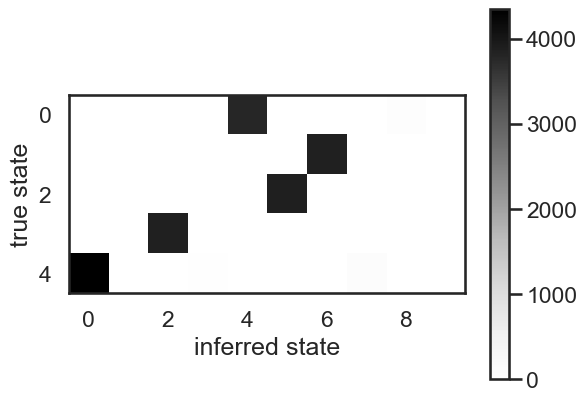

In [80]:
z_overlap = jnp.zeros((true_num_states, num_states))
# Loop over sessions and pairs of states
for z, true_z in zip(model["states"]["z"], true_zs):
    for i in range(true_num_states):
        for j in range(num_states):
            z_overlap = z_overlap.at[i, j].add(jnp.sum((true_z[1:] == i) & (z == j)))

plt.imshow(z_overlap, cmap="Greys", interpolation="nearest", aspect="1")
plt.colorbar()
plt.xlabel("inferred state")
plt.ylabel("true state")

Text(0, 0.5, 'true tau')

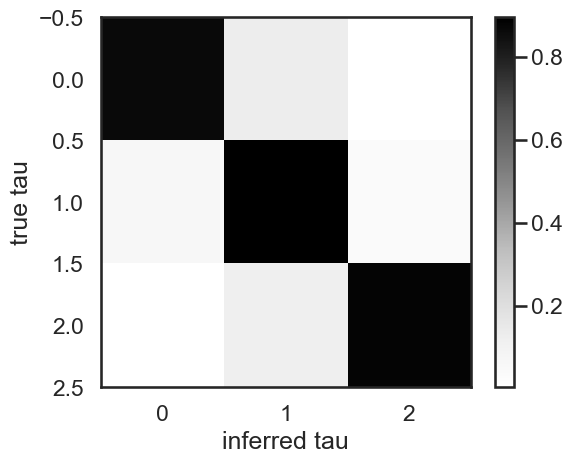

In [81]:
true_num_taus = num_taus = 3
t_overlap = jnp.zeros((true_num_taus, num_taus))
# Loop over sessions and pairs of taus
for t, true_t in zip(model["states"]["t"], true_ts):
    for i in range(true_num_taus):
        for j in range(num_taus):
            t_overlap = t_overlap.at[i, j].add(jnp.sum((true_t[1:] == i) & (t == j)))

plt.imshow(t_overlap / t_overlap.sum(axis=1, keepdims=True), 
           cmap="Greys", interpolation="nearest", aspect="1")
plt.colorbar()
plt.xlabel("inferred tau")
plt.ylabel("true tau")